# Cleaning and Preprocessing

In [160]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import zipfile
import pandas as pd
from io import StringIO
from scipy.io import arff
import requests

# Function to download the file from Google Drive
def download_file_from_google_drive(id, destination):
    url = f"https://drive.google.com/uc?export=download&id={id}"
    response = requests.get(url, stream=True)
    with open(destination, "wb") as f:
        f.write(response.content)

def unzip_and_read_arff(zip_file_path, arff_file_name):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            with zip_ref.open(arff_file_name) as arff_file:
                arff_data = arff_file.read().decode('utf-8')
                arff_data_stream = StringIO(arff_data)
                data, meta = arff.loadarff(arff_data_stream)
                df = pd.DataFrame(data)
                return df
    except FileNotFoundError:
        print(f"File not found: {zip_file_path}")
    except zipfile.BadZipFile:
        print(f"Invalid zip file: {zip_file_path}")
    except KeyError:
        print(f"ARFF file not found in zip: {arff_file_name}")

# Google Drive file ID
file_id = "1Ei2NxZfXiYJAK32WsD_Y-xnnrnOBqKPD"
# Destination to save the downloaded zip file
zip_file_path = "elecNormNew.arff (1).zip"

# Download the file
download_file_from_google_drive(file_id, zip_file_path)

# Name of the ARFF file within the zip
arff_file_name = "elecNormNew.arff"

# Unzip and read the ARFF file into a DataFrame
elec_df = unzip_and_read_arff(zip_file_path, arff_file_name)
print(elec_df)

         date   day    period  nswprice  nswdemand  vicprice  vicdemand  \
0      0.0000  b'2'  0.000000  0.056443   0.439155  0.003467   0.422915   
1      0.0000  b'2'  0.021277  0.051699   0.415055  0.003467   0.422915   
2      0.0000  b'2'  0.042553  0.051489   0.385004  0.003467   0.422915   
3      0.0000  b'2'  0.063830  0.045485   0.314639  0.003467   0.422915   
4      0.0000  b'2'  0.085106  0.042482   0.251116  0.003467   0.422915   
...       ...   ...       ...       ...        ...       ...        ...   
45307  0.9158  b'7'  0.914894  0.044224   0.340672  0.003033   0.255049   
45308  0.9158  b'7'  0.936170  0.044884   0.355549  0.003072   0.241326   
45309  0.9158  b'7'  0.957447  0.043593   0.340970  0.002983   0.247799   
45310  0.9158  b'7'  0.978723  0.066651   0.329366  0.004630   0.345417   
45311  0.9158  b'7'  1.000000  0.050679   0.288753  0.003542   0.355256   

       transfer    class  
0      0.414912    b'UP'  
1      0.414912    b'UP'  
2      0.414912   

In [162]:
# Convert byte columns to strings and strip leading/trailing whitespace
columns = ['day', 'class']
for col in columns:
    elec_df[col] = elec_df[col].str.decode('utf-8').str.strip()

In [163]:
# Convert class column to binary and day column to integer type
elec_df['class'] = elec_df['class'].map({'UP': 1, 'DOWN': 0})
elec_df['day'] = elec_df['day'].astype(int)

In [164]:
print(elec_df.dtypes)

date         float64
day            int64
period       float64
nswprice     float64
nswdemand    float64
vicprice     float64
vicdemand    float64
transfer     float64
class          int64
dtype: object


In [165]:
print(len(elec_df))

45312


In [166]:
# Print value counts for class columns
class_counts = elec_df['class'].value_counts()
print(class_counts)

class
0    26075
1    19237
Name: count, dtype: int64


In [167]:
# Check for missing values
print(elec_df.isnull().sum())

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64


In [168]:
import numpy as np
# Identify outliers using Inter Quartile method
def find_outliers(df):
    outliers = {}
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Only apply to numerical columns
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

outliers = find_outliers(elec_df)

for feature, outlier_values in outliers.items():
    print(f"Outliers in {feature}:")
    print(outlier_values)
    print()

Outliers in date:
Series([], Name: date, dtype: float64)

Outliers in day:
Series([], Name: day, dtype: int64)

Outliers in period:
Series([], Name: period, dtype: float64)

Outliers in nswprice:
162      0.149664
167      0.146902
168      0.193287
169      0.193287
170      0.194548
           ...   
44716    0.143509
44718    0.139276
44719    0.146211
44720    0.137144
44863    0.134562
Name: nswprice, Length: 890, dtype: float64

Outliers in nswdemand:
3347     0.884707
3348     0.898096
3395     0.909997
3396     0.922642
3397     0.900922
           ...   
39158    0.884261
39491    0.895269
39492    0.900327
39493    0.877715
39539    0.880244
Name: nswdemand, Length: 83, dtype: float64

Outliers in vicprice:
17433    0.000000
17434    0.000000
17435    0.000000
17436    0.000000
17437    0.000000
           ...   
45266    0.005268
45280    0.005675
45281    0.005548
45282    0.005577
45283    0.005332
Name: vicprice, Length: 3683, dtype: float64

Outliers in vicdemand:
17428 

In [169]:
# Start date for the dataset
start_date = pd.to_datetime('1996-05-07')

num_records = len(elec_df)

# Generate datetime range with 30-minute intervals
date_range = pd.date_range(start=start_date, periods=num_records, freq='30T')

# Add the datetime column to the DataFrame
elec_df['datetime'] = date_range

print(f"Date range: {elec_df['datetime'].min()} to {elec_df['datetime'].max()}")

Date range: 1996-05-07 00:00:00 to 1998-12-06 23:30:00


In [170]:
# Define the split date based on national electricity market (NEM)
split_date = pd.to_datetime('1997-05-02') # Introduction of national electricity market (NEM)

# Split the dataset
elec_df_1 = elec_df[elec_df['datetime'] <= split_date]
elec_df_2 = elec_df[elec_df['datetime'] > split_date]

# Verify the splits
print(f"First dataset shape: {elec_df_1.shape}")
print(f"Second dataset shape: {elec_df_2.shape}")

# Ensure the intervals are 30 minutes
time_deltas = elec_df['datetime'].diff().dropna()
intervals_are_30min = all(time_deltas == pd.Timedelta(minutes=30))

print(f"All intervals are 30 minutes: {intervals_are_30min}")

First dataset shape: (17281, 10)
Second dataset shape: (28031, 10)
All intervals are 30 minutes: True


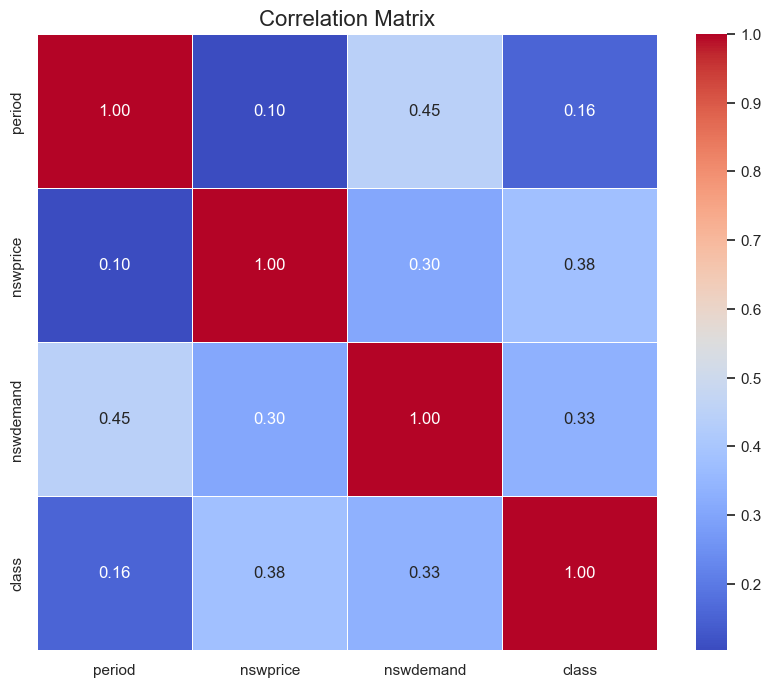

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = elec_df.drop(columns = ['date','day','vicprice','vicdemand','transfer','datetime']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# Functions

In [172]:
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [173]:
!pip install SHAP


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [174]:
# Function to calculate Permutation Importance Scores for chunks
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
def calculate_permutation_importance_chunks(model, X, y, chunk_size=1000):
  all_importance_scores = []
  for i in range(0, len(X), chunk_size):
    chunk_X = X[i: i + chunk_size]
    chunk_y = y[i: i + chunk_size]
    if hasattr(model, 'get_weights'): # To take care of neural networks and other models
      results = permutation_importance(model, chunk_X, chunk_y, scoring='neg_root_mean_squared_error', random_state=42)
    else:
      results = permutation_importance(model, chunk_X, chunk_y, scoring='accuracy', random_state=42)
    importance_scores = results.importances_mean
    all_importance_scores.append(importance_scores)

  return pd.DataFrame(all_importance_scores, columns=X.columns)

In [175]:
from sklearn.metrics import accuracy_score

def calculate_permutation_importance_all_values(model, X, y, chunk_size=1000):
    all_importance_data = []
    accuracy_data = []

    for i in range(0, len(X), chunk_size):
        chunk_X = X.iloc[i: i + chunk_size]
        chunk_y = y.iloc[i: i + chunk_size]
        chunk_number = i // chunk_size + 1

        if hasattr(model, 'get_weights'):  # In case of neural networks
            predictions = (model.predict(chunk_X) > 0.5).astype("int32").flatten()
            accuracy = accuracy_score(chunk_y, predictions)
            accuracy_data.append([chunk_number, accuracy])
            results = permutation_importance(model, chunk_X, chunk_y, scoring='neg_root_mean_squared_error', random_state=42)
        
        else:  # Non-neural network case
            accuracy = model.score(chunk_X, chunk_y)
            accuracy_data.append([chunk_number, accuracy])
            results = permutation_importance(model, chunk_X, chunk_y, scoring='accuracy', random_state=42)

        importances = results.importances

        # Reshape the data and add the chunk number
        for j in range(importances.shape[1]):  # iterate over features
            if j < len(chunk_X.columns):
                for k in range(importances.shape[0]):  # iterate over importance scores
                    all_importance_data.append([chunk_number, X.columns[j], importances[k, j]])

    importance_df = pd.DataFrame(all_importance_data, columns=['chunk_number', 'feature', 'importance'])
    accuracy_df = pd.DataFrame(accuracy_data, columns=['chunk_number', 'accuracy'])

    return importance_df, accuracy_df

In [176]:
# Function to plot the permutation importance scores
import matplotlib.pyplot as plt
import seaborn as sns
def plot_permutation_importance(importance_df):
# Calculate mean importance scores across chunks
  mean_importance_scores = importance_df.mean()

# Create a DataFrame for plotting
  mean_importance_df = pd.DataFrame({
      'Feature': mean_importance_scores.index,
      'Importance': mean_importance_scores.values
  })
  print(mean_importance_df)
# Plot mean importance scores
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Feature', y='Importance', data=mean_importance_df, palette='viridis')
  plt.title('Mean Permutation Importance of Features')
  plt.xlabel('Feature')
  plt.ylabel('Mean Importance')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
  plt.tight_layout()
  plt.show()
  return mean_importance_df

In [177]:
def find_highest_percentage_change(df):
    # Calculate percentage change between consecutive windows for each feature
    df_pct_change = df.pct_change() * 100  # Convert to percentage
    df_pct_change = df_pct_change.dropna()  # Remove NaN values from the first row

    # Dictionary to store the results
    results = {}

    # Iterate over all columns to find the window pair with the highest percentage change
    for feature in df.columns:
        max_change = float('-inf')
        from_window, to_window = None, None

        for i in range(1, len(df_pct_change)):
            pct_change = df_pct_change[feature].iloc[i]
            if abs(pct_change) > abs(max_change):
                max_change = pct_change
                from_window = df_pct_change.index[i - 1]
                to_window = df_pct_change.index[i]

        results[feature] = {
            'max_change': max_change,
            'from_window': from_window,
            'to_window': to_window
        }

    # Print the results
    for feature, change_info in results.items():
        print(f"Feature: {feature}")
        print(f"Highest Percentage Change: {change_info['max_change']:.6f}%")
        print(f"From Window {change_info['from_window']} to Window {change_info['to_window']}\n")


In [178]:
# Function to plot SHAP graph
from scipy.stats import skew
import shap
def plot_linear_shap_graph(X,model):
  masker = shap.maskers.Independent(X)
  # Create a SHAP explainer for linear models
  explainer = shap.LinearExplainer(model, masker=masker)
  shap_values = explainer.shap_values(X)
  shap.summary_plot(shap_values, X)
  shap_df = pd.DataFrame(shap_values, columns=X.columns)
  return shap_df
def plot_tree_shap_graph(X,model):
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X, approximate=True)
  shap.summary_plot(shap_values[:, :, 1], X)
  shap_df = pd.DataFrame(shap_values[:, :, 1], columns=X.columns)
  return shap_df

def plot_nn_shap_graph(X, model):
  X_sample = X
  # Initialize the explainer
  X_sample_np = X_sample.values
  explainer = shap.DeepExplainer(model, X_sample)
  shap_values = explainer.shap_values(X_sample_np)
  shap_values_reshaped = shap_values.reshape(len(X_sample),3)
  shap.summary_plot(shap_values_reshaped, X_sample)
  shap_df = pd.DataFrame(shap_values_reshaped, columns=X.columns)
  return shap_df

In [179]:
# Calculate skewness, variance, mean from SHAP values for random forest
import numpy as np
def calculate_shap_metrics_rf(shap_values,features):
  metrics = []
  for i, feature_name in enumerate(features):
    feature_shap_values = shap_values[:,i,1]
    mean_value = np.mean(feature_shap_values)
    variance_value = np.var(feature_shap_values)
    skewness_value = skew(feature_shap_values)
    metrics.append({
        'feature': feature_name,
        'mean': mean_value,
        'variance': variance_value,
        'skewness': skewness_value
    })
  metrics_df = pd.DataFrame(metrics)
  return metrics_df

# Calculate skewness, variance, mean from SHAP values
def calculate_shap_metrics_lr(shap_values):
    metrics = []    
    for feature_name in shap_values.columns:
        feature_shap_values = shap_values[feature_name].values  # Extract SHAP values for the feature
        mean_value = np.mean(feature_shap_values)
        variance_value = np.var(feature_shap_values)
        skewness_value = skew(feature_shap_values)
        metrics.append({
            'feature': feature_name,
            'mean': mean_value,
            'variance': variance_value,
            'skewness': skewness_value
        })
    
    # Convert the list of metrics into a DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df

In [180]:
# Function to plot accuracy scores across windows
def plot_accuracy(accuracy_df):
    plt.figure(figsize=(10, 6))

    sns.lineplot(x='chunk_number', y='accuracy', data=accuracy_df, marker='o', color='blue', label='Accuracy')
    sns.regplot(x='chunk_number', y='accuracy', data=accuracy_df, scatter=False, color='red', line_kws={'label': 'Trend Line'})

    plt.title('Model Accuracy Across Testing Period')
    plt.xlabel('Chunk Number')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [181]:
from scipy.stats import ttest_ind, ks_2samp
# Function to identify statistical differences
def print_significant_differences(df, alpha=0.05):
    for feature in df['feature'].unique():
        feature_data = df[df['feature'] == feature]
        previous_chunk_importances = None

        # Iterate over each chunk for the feature
        for chunk_number in sorted(feature_data['chunk_number'].unique()):
            current_chunk_importances = feature_data[feature_data['chunk_number'] == chunk_number]['importance']

            if previous_chunk_importances is not None:
                # Perform t-test
                t_stat, t_p_value = ttest_ind(previous_chunk_importances, current_chunk_importances, equal_var=False)

                # Perform KS-test
                ks_stat, ks_p_value = ks_2samp(previous_chunk_importances, current_chunk_importances)

                # Check if the p-values are less than the significance level alpha
                if t_p_value < alpha:
                    print(f"Significant t-test difference for feature '{feature}' in chunk {chunk_number}. p-value: {t_p_value:.5f}")
                
                if ks_p_value < alpha:
                    print(f"Significant KS-test difference for feature '{feature}' in chunk {chunk_number}. p-value: {ks_p_value:.5f}")

            previous_chunk_importances = current_chunk_importances

In [182]:
# Function to perform t-test and KS-test for MCR bounds
import scipy.stats as stats
def compare_mcr_bounds(mcr_weekday_df, mcr_weekend_df):

    significant_features_ttest = []
    significant_features_kstest = []
    p_values_ttest = {}
    p_values_kstest = {}
    
    # Compute the differences for both datasets
    mcr_weekday_df['MCR_Diff'] = mcr_weekday_df['MCR+'] - mcr_weekday_df['MCR-']
    mcr_weekend_df['MCR_Diff'] = mcr_weekend_df['MCR+'] - mcr_weekend_df['MCR-']
    
    for feature in mcr_weekday_df['Feature']:
        weekday_mcr_diff = mcr_weekday_df[mcr_weekday_df['Feature'] == feature]['MCR_Diff'].values
        weekend_mcr_diff = mcr_weekend_df[mcr_weekend_df['Feature'] == feature]['MCR_Diff'].values
        
        # Perform t-test
        ttest = stats.ttest_ind(weekday_mcr_diff, weekend_mcr_diff, equal_var=False)
        p_values_ttest[feature] = ttest.pvalue
        
        # Perform KS-test
        kstest = stats.ks_2samp(weekday_mcr_diff, weekend_mcr_diff)
        p_values_kstest[feature] = kstest.pvalue
        
        # Check if the p-value for t-test is less than 0.05
        if ttest.pvalue < 0.05:
            significant_features_ttest.append((feature, ttest.pvalue))
        
        # Check if the p-value for KS-test is less than 0.05
        if kstest.pvalue < 0.05:
            significant_features_kstest.append((feature, kstest.pvalue))
    
    print("Features with significant differences (p < 0.05) according to the T-test:")
    for feature, p_value in significant_features_ttest:
        print(f"- {feature}: p-value = {p_value:.4f}")
    
    print("\nFeatures with significant differences (p < 0.05) according to the KS-test:")
    for feature, p_value in significant_features_kstest:
        print(f"- {feature}: p-value = {p_value:.4f}")

# Model Logistic Regression

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Subset the first 10 months data for training (approx 1500 records per month)
training_df = elec_df.iloc[:15000]

# Define features and target
X = training_df[['period','nswprice','nswdemand']] # Excluding constant variables in training period - 'vicprice','vicdemand','transfer']]
y = training_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1469  179]
 [ 437  915]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1648
           1       0.84      0.68      0.75      1352

    accuracy                           0.79      3000
   macro avg       0.80      0.78      0.79      3000
weighted avg       0.80      0.79      0.79      3000



In [184]:
# Set next 10 months as testing dataset for postdrift analysis
testing_df = elec_df.iloc[15000:30000].reset_index(drop=True)

In [185]:
# Define features and target for testing dataframe
X2 = testing_df[['period','nswprice','nswdemand']]
y2 = testing_df['class']

In [186]:
# Make predictions on the test set
y2_pred = lr_model.predict(X2)

print("Confusion Matrix:")
print(confusion_matrix(y2, y2_pred))

print("\nClassification Report:")
print(classification_report(y2, y2_pred))

Confusion Matrix:
[[8880  105]
 [4414 1601]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      8985
           1       0.94      0.27      0.41      6015

    accuracy                           0.70     15000
   macro avg       0.80      0.63      0.61     15000
weighted avg       0.78      0.70      0.64     15000



In [187]:
# Calculate permutation importance chunk wise
lr_importance_df = calculate_permutation_importance_chunks(lr_model, X2, y2, chunk_size=1500)

In [188]:
lr_importance_df

,period,nswprice,nswdemand
0,0.008267,0.126933,0.038133
1,-0.003200,0.178533,0.033200
2,0.007200,0.172933,0.046400
3,0.004800,0.104533,0.031067
4,0.002667,0.141333,0.027733
5,0.003067,0.041200,0.013467
6,0.000800,0.114267,0.004800
7,0.003067,0.059467,0.031200
8,-0.001067,0.042133,0.006400
9,0.000000,0.020400,0.007867


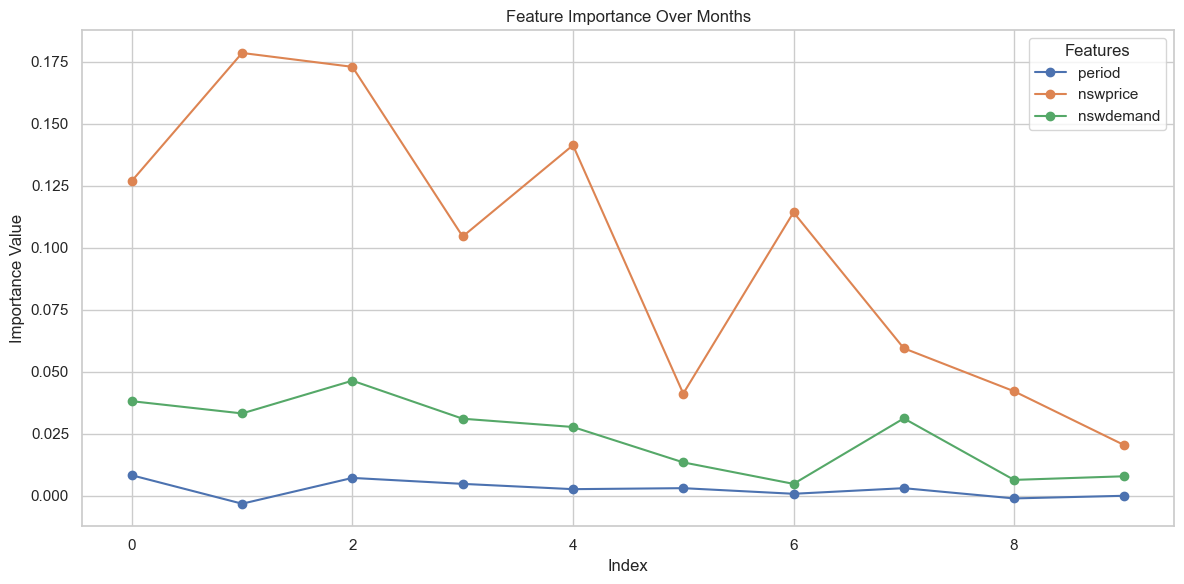

In [189]:
# Plot the permutation importance scores across testing windows
fig, ax = plt.subplots(figsize=(12, 6))
# Plot each feature
for feature in ['period','nswprice', 'nswdemand']:
    ax.plot(lr_importance_df.index, lr_importance_df[feature], marker='o', label=feature)

ax.set_xlabel('Index')
ax.set_ylabel('Importance Value')
ax.set_title('Feature Importance Over Months')
ax.legend(title='Features', loc='upper right')
plt.tight_layout()
plt.show()

In [190]:
# Calculate chunk wise accuracy and VIM for statistical tests across windows
lr_importance_stat, lr_accuracy = calculate_permutation_importance_all_values(lr_model, X2, y2, chunk_size=1500)

In [191]:
lr_importance_stat

,chunk_number,feature,importance
0,1,period,0.007333
1,1,period,0.122000
2,1,period,0.030667
3,1,nswprice,0.008667
4,1,nswprice,0.123333
...,...,...,...
85,10,nswprice,0.021333
86,10,nswprice,0.006667
87,10,nswdemand,0.000667
88,10,nswdemand,0.021333


In [192]:
# Check for statistical differences
print_significant_differences(lr_importance_stat, alpha=0.05)

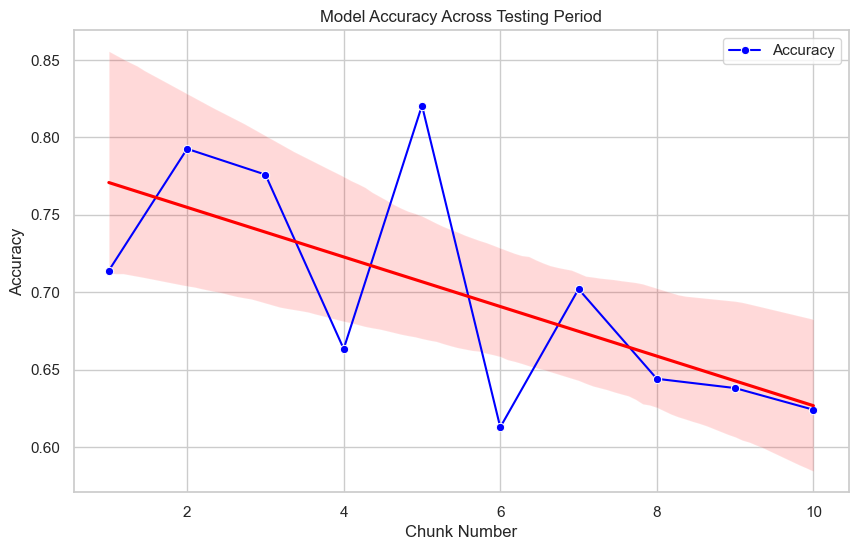

In [193]:
plot_accuracy(lr_accuracy)

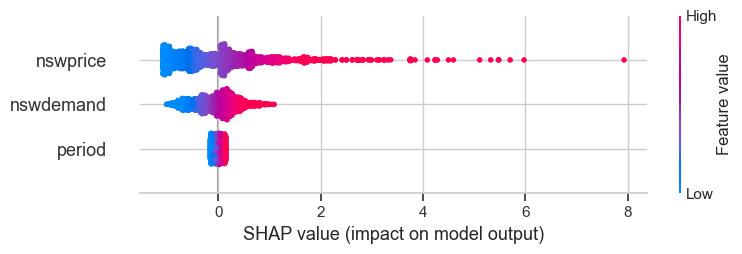

In [194]:
# SHAP Summary plot for training dataset
lr_shap_values = plot_linear_shap_graph(X_test,lr_model)

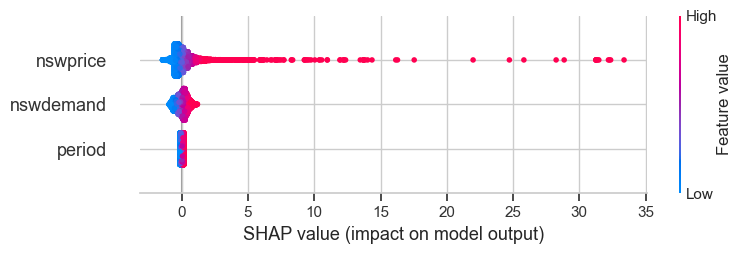

In [195]:
# SHAP summary plot for testing dataset
lr_test_shap_values = plot_linear_shap_graph(X2,lr_model)

In [196]:
# Calculate SHAP metrics for observing differences in Mean, Variance and Skewness of SHAP values
lr_shap_metrics = calculate_shap_metrics_lr(lr_shap_values)
lr_shap_metrics

,feature,mean,variance,skewness
0,period,-0.009399,0.007573,0.009235
1,nswprice,-0.000395,0.849165,1.705465
2,nswdemand,-0.050105,0.145303,-0.157606


In [197]:
lr_test_shap_metrics = calculate_shap_metrics_lr(lr_test_shap_values)
lr_test_shap_metrics

,feature,mean,variance,skewness
0,period,0.007460,0.007681,-0.002080
1,nswprice,0.184366,1.838239,13.627892
2,nswdemand,0.016223,0.156430,-0.108864


In [198]:
# Using statistical tests identify if SHAP metrics are significantly different
# Extract the statistics from the DataFrames
train_stats = lr_shap_metrics.set_index('feature').to_dict('index')
test_stats = lr_test_shap_metrics.set_index('feature').to_dict('index')

n_samples = 1000
significance_level = 0.05

# Function to simulate SHAP values based on mean and variance
def simulate_shap_values(mean, variance, n_samples):
    return np.random.normal(loc=mean, scale=np.sqrt(variance), size=n_samples)

# Simulating SHAP values for training and testing datasets
shap_train = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
              for feature, stats in train_stats.items()}

shap_test = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
             for feature, stats in test_stats.items()}

# Perform t-test and KS-test for each feature
test_results = {}
for feature in shap_train.keys():
    t_stat, t_p_value = ttest_ind(shap_train[feature], shap_test[feature], equal_var=True)
    ks_stat, ks_p_value = ks_2samp(shap_train[feature], shap_test[feature])
    
    # Determine if the results are significant
    t_significant = t_p_value < significance_level
    ks_significant = ks_p_value < significance_level
    
    test_results[feature] = {
        't-test': {'t_stat': t_stat, 'p_value': t_p_value, 'significant': t_significant},
        'ks-test': {'ks_stat': ks_stat, 'p_value': ks_p_value, 'significant': ks_significant}
    }

# Print results and highlight which are significantly different
for feature, results in test_results.items():
    print(f"Feature: {feature}")
    print(f"  t-test: t_stat={results['t-test']['t_stat']:.4f}, p_value={results['t-test']['p_value']:.4e}, "
          f"{'Significant' if results['t-test']['significant'] else 'Not Significant'}")
    print(f"  KS-test: ks_stat={results['ks-test']['ks_stat']:.4f}, p_value={results['ks-test']['p_value']:.4e}, "
          f"{'Significant' if results['ks-test']['significant'] else 'Not Significant'}")
    print()

print("Summary of features with significant differences:")
for feature, results in test_results.items():
    if results['t-test']['significant'] or results['ks-test']['significant']:
        print(f"Feature: {feature}")
        if results['t-test']['significant']:
            print(f"  Significant difference in mean based on t-test (p={results['t-test']['p_value']:.4e})")
        if results['ks-test']['significant']:
            print(f"  Significant difference in distribution based on KS-test (p={results['ks-test']['p_value']:.4e})")

Feature: period
  t-test: t_stat=-6.1299, p_value=1.0565e-09, Significant
  KS-test: ks_stat=0.1320, p_value=5.1948e-08, Significant

Feature: nswprice
  t-test: t_stat=-4.6048, p_value=4.3882e-06, Significant
  KS-test: ks_stat=0.1600, p_value=1.3829e-11, Significant

Feature: nswdemand
  t-test: t_stat=-3.0364, p_value=2.4253e-03, Significant
  KS-test: ks_stat=0.0660, p_value=2.5634e-02, Significant

Summary of features with significant differences:
Feature: period
  Significant difference in mean based on t-test (p=1.0565e-09)
  Significant difference in distribution based on KS-test (p=5.1948e-08)
Feature: nswprice
  Significant difference in mean based on t-test (p=4.3882e-06)
  Significant difference in distribution based on KS-test (p=1.3829e-11)
Feature: nswdemand
  Significant difference in mean based on t-test (p=2.4253e-03)
  Significant difference in distribution based on KS-test (p=2.5634e-02)


In [199]:
lr_shap_metrics

,feature,mean,variance,skewness
0,period,-0.009399,0.007573,0.009235
1,nswprice,-0.000395,0.849165,1.705465
2,nswdemand,-0.050105,0.145303,-0.157606


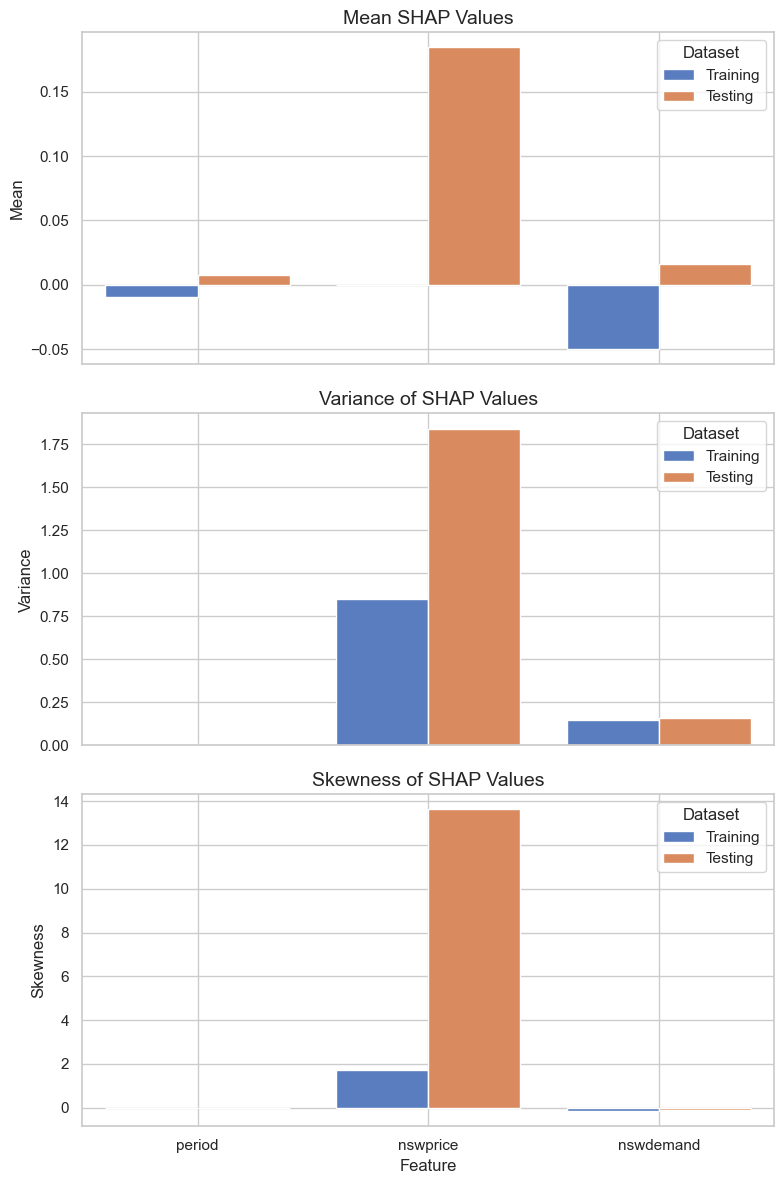

In [200]:
# Plot SHAP Metrics
lr_shap_metrics['Dataset'] = 'Training'
lr_test_shap_metrics['Dataset'] = 'Testing'

# Combine the two dataframes into one
combined_shap_metrics = pd.concat([lr_shap_metrics, lr_test_shap_metrics])


sns.set(style="whitegrid")
palette = sns.color_palette("muted")
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot mean SHAP values
sns.barplot(ax=axes[0], x='feature', y='mean', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[0].set_title('Mean SHAP Values', fontsize=14)
axes[0].set_ylabel('Mean', fontsize=12)
axes[0].grid(True)

# Plot variance of SHAP values
sns.barplot(ax=axes[1], x='feature', y='variance', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[1].set_title('Variance of SHAP Values', fontsize=14)
axes[1].set_ylabel('Variance', fontsize=12)
axes[1].grid(True)

# Plot skewness of SHAP values
sns.barplot(ax=axes[2], x='feature', y='skewness', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[2].set_title('Skewness of SHAP Values', fontsize=14)
axes[2].set_xlabel('Feature', fontsize=12)
axes[2].set_ylabel('Skewness', fontsize=12)
axes[2].grid(True)

plt.tight_layout()

plt.show()

# Model Random Forest

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Subset the first 15,000 records for training (first 10 months)
training_df = elec_df.iloc[:15000]

X = training_df[['period','nswprice','nswdemand']]
y = training_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))


Confusion Matrix (Random Forest):
[[1441  207]
 [ 276 1076]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1648
           1       0.84      0.80      0.82      1352

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [202]:
# Set next 10 months data as testing dataset
testing_df = elec_df.iloc[15000:30000].reset_index(drop=True)

In [203]:
# Define features and target for testing dataset
X2 = testing_df[['period','nswprice','nswdemand']]
y2 = testing_df['class']

In [204]:
# Calculate permutation importance for testing dataset chunk wise
rf_importance_df = calculate_permutation_importance_chunks(rf_model, X2, y2, chunk_size=1500)

In [205]:
# Make predictions on the test set
y2_pred = rf_model.predict(X2)

print("Confusion Matrix:")
print(confusion_matrix(y2, y2_pred))

print("\nClassification Report:")
print(classification_report(y2, y2_pred))

Confusion Matrix:
[[8815  170]
 [4566 1449]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.98      0.79      8985
           1       0.89      0.24      0.38      6015

    accuracy                           0.68     15000
   macro avg       0.78      0.61      0.58     15000
weighted avg       0.75      0.68      0.62     15000



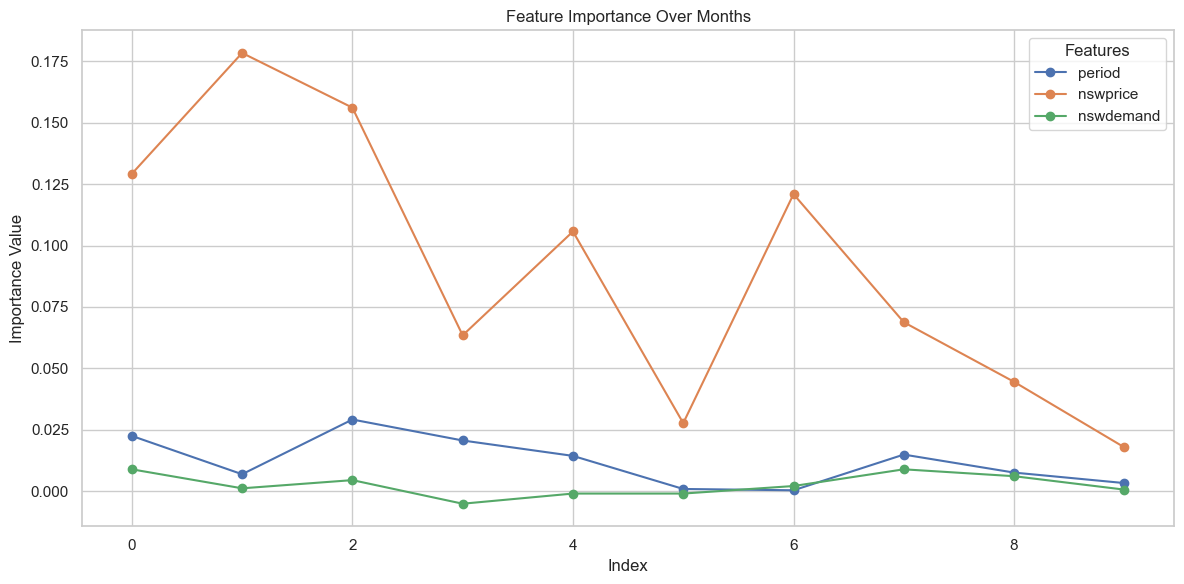

In [206]:
# Plot importance scores across windows
fig, ax = plt.subplots(figsize=(12, 6))

for feature in ['period','nswprice', 'nswdemand']:
    ax.plot(rf_importance_df.index, rf_importance_df[feature], marker='o', label=feature)


ax.set_xlabel('Index')
ax.set_ylabel('Importance Value')
ax.set_title('Feature Importance Over Months')
ax.legend(title='Features', loc='upper right')
plt.tight_layout()
plt.show()

In [207]:
# Calculate metrics for statistical analysis
rf_importance_stat, rf_accuracy = calculate_permutation_importance_all_values(rf_model, X2, y2, chunk_size=1500)

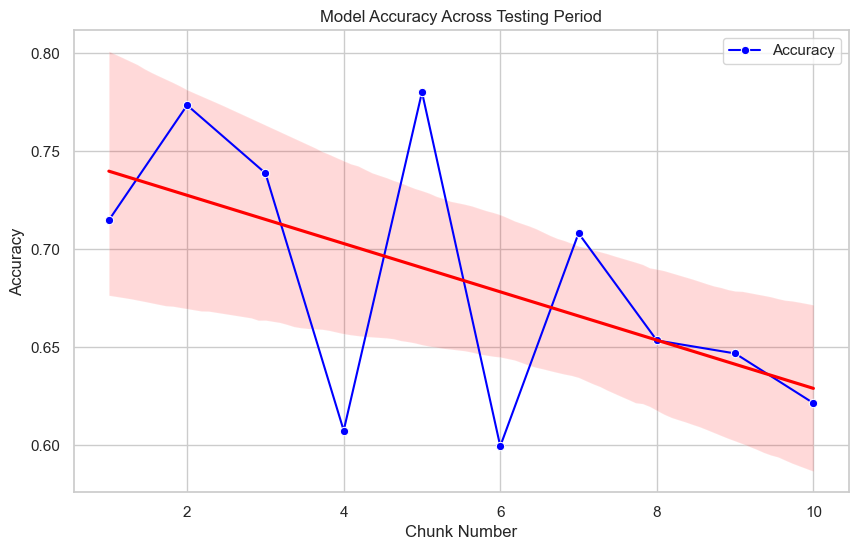

In [208]:
# Plot accuracy scores per window
plot_accuracy(rf_accuracy)

In [209]:
# Identify statstical differences in importance scores
print_significant_differences(rf_importance_stat, alpha=0.05)

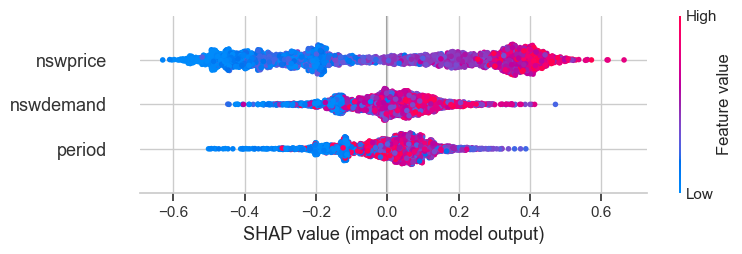

In [210]:
# SHAP summary plot for training dataset
rf_shap_values = plot_tree_shap_graph(X_test,rf_model)

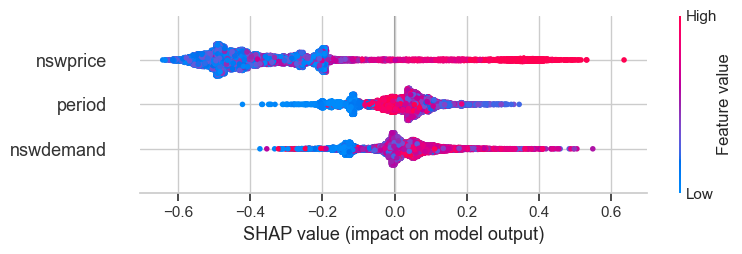

In [211]:
# SHAP summary plot for testing dataset
rf_test_shap_values = plot_tree_shap_graph(X2,rf_model)

In [212]:
# Calculate mean, variance and skewness of SHAP values
rf_shap_metrics = calculate_shap_metrics_lr(rf_shap_values)

In [213]:
rf_shap_metrics

,feature,mean,variance,skewness
0,period,0.000213,0.013576,-0.615372
1,nswprice,-0.010026,0.104210,-0.047947
2,nswdemand,0.001538,0.014454,-0.231805


In [214]:
rf_test_shap_metrics = calculate_shap_metrics_lr(rf_test_shap_values)
rf_test_shap_metrics

,feature,mean,variance,skewness
0,period,0.007395,0.008936,-0.435681
1,nswprice,-0.318760,0.054317,1.622288
2,nswdemand,0.012264,0.009597,0.157058


In [215]:
# Perform statistical tests on SHAP metrics

train_stats = rf_shap_metrics.set_index('feature').to_dict('index')
test_stats = rf_test_shap_metrics.set_index('feature').to_dict('index')
n_samples = 1000
significance_level = 0.05

def simulate_shap_values(mean, variance, n_samples):
    return np.random.normal(loc=mean, scale=np.sqrt(variance), size=n_samples)

# Simulating SHAP values for training and testing datasets
shap_train = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
              for feature, stats in train_stats.items()}

shap_test = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
             for feature, stats in test_stats.items()}

# Perform t-test and KS-test for each feature
test_results = {}
for feature in shap_train.keys():
    t_stat, t_p_value = ttest_ind(shap_train[feature], shap_test[feature], equal_var=True)
    ks_stat, ks_p_value = ks_2samp(shap_train[feature], shap_test[feature])
    
    # Determine if the results are significant
    t_significant = t_p_value < significance_level
    ks_significant = ks_p_value < significance_level
    
    test_results[feature] = {
        't-test': {'t_stat': t_stat, 'p_value': t_p_value, 'significant': t_significant},
        'ks-test': {'ks_stat': ks_stat, 'p_value': ks_p_value, 'significant': ks_significant}
    }

# Print results and highlight which are significantly different
for feature, results in test_results.items():
    print(f"Feature: {feature}")
    print(f"  t-test: t_stat={results['t-test']['t_stat']:.4f}, p_value={results['t-test']['p_value']:.4e}, "
          f"{'Significant' if results['t-test']['significant'] else 'Not Significant'}")
    print(f"  KS-test: ks_stat={results['ks-test']['ks_stat']:.4f}, p_value={results['ks-test']['p_value']:.4e}, "
          f"{'Significant' if results['ks-test']['significant'] else 'Not Significant'}")
    print()

print("Summary of features with significant differences:")
for feature, results in test_results.items():
    if results['t-test']['significant'] or results['ks-test']['significant']:
        print(f"Feature: {feature}")
        if results['t-test']['significant']:
            print(f"  Significant difference in mean based on t-test (p={results['t-test']['p_value']:.4e})")
        if results['ks-test']['significant']:
            print(f"  Significant difference in distribution based on KS-test (p={results['ks-test']['p_value']:.4e})")

Feature: period
  t-test: t_stat=-1.0862, p_value=2.7753e-01, Not Significant
  KS-test: ks_stat=0.0800, p_value=3.3111e-03, Significant

Feature: nswprice
  t-test: t_stat=24.1104, p_value=5.9895e-113, Significant
  KS-test: ks_stat=0.4550, p_value=1.1211e-93, Significant

Feature: nswdemand
  t-test: t_stat=-2.4056, p_value=1.6236e-02, Significant
  KS-test: ks_stat=0.0900, p_value=6.0290e-04, Significant

Summary of features with significant differences:
Feature: period
  Significant difference in distribution based on KS-test (p=3.3111e-03)
Feature: nswprice
  Significant difference in mean based on t-test (p=5.9895e-113)
  Significant difference in distribution based on KS-test (p=1.1211e-93)
Feature: nswdemand
  Significant difference in mean based on t-test (p=1.6236e-02)
  Significant difference in distribution based on KS-test (p=6.0290e-04)


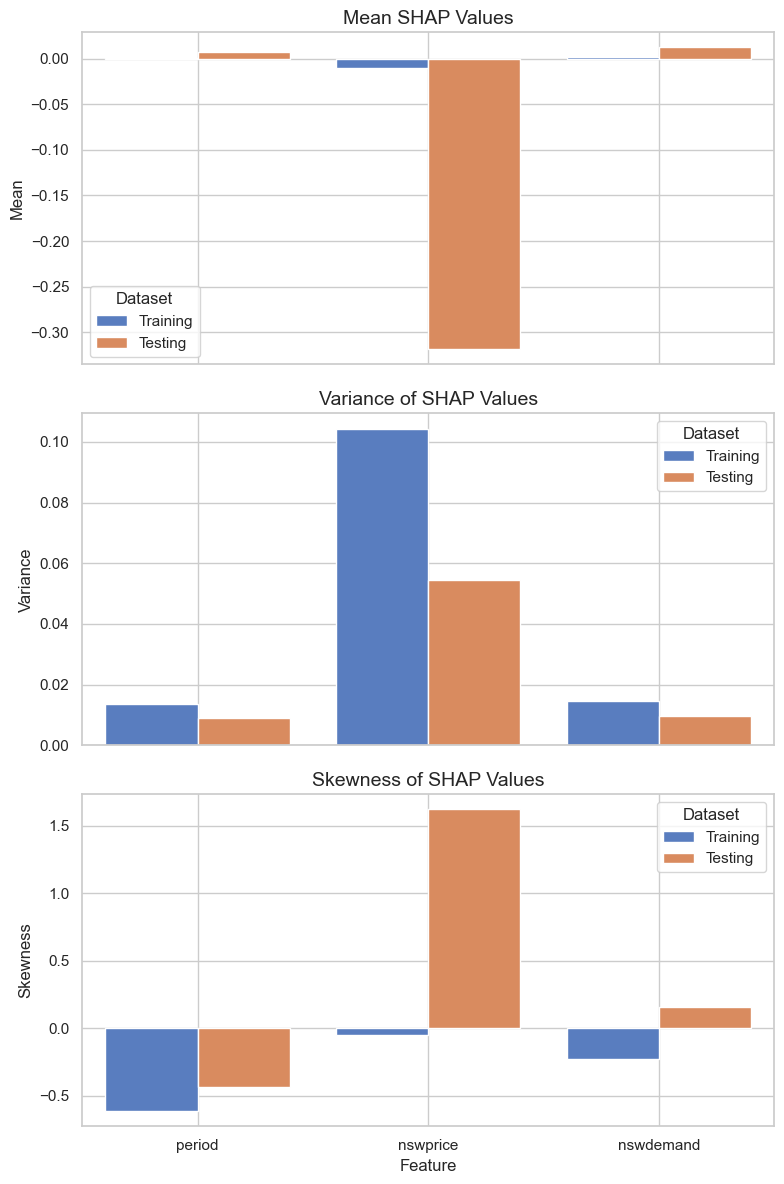

In [216]:
# Plot SHAP metrics

rf_shap_metrics['Dataset'] = 'Training'
rf_test_shap_metrics['Dataset'] = 'Testing'

# Combine the two dataframes into one
combined_shap_metrics = pd.concat([rf_shap_metrics, rf_test_shap_metrics])

import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
palette = sns.color_palette("muted")
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot mean SHAP values
sns.barplot(ax=axes[0], x='feature', y='mean', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[0].set_title('Mean SHAP Values', fontsize=14)
axes[0].set_ylabel('Mean', fontsize=12)
axes[0].grid(True)

# Plot variance of SHAP values
sns.barplot(ax=axes[1], x='feature', y='variance', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[1].set_title('Variance of SHAP Values', fontsize=14)
axes[1].set_ylabel('Variance', fontsize=12)
axes[1].grid(True)

# Plot skewness of SHAP values
sns.barplot(ax=axes[2], x='feature', y='skewness', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[2].set_title('Skewness of SHAP Values', fontsize=14)
axes[2].set_xlabel('Feature', fontsize=12)
axes[2].set_ylabel('Skewness', fontsize=12)
axes[2].grid(True)


plt.tight_layout()
plt.show()

In [217]:
# Calculate MCR bounds for Random Forests - Weekday dataset
from sklearn.metrics import accuracy_score
# Calculate the baseline accuracy on the test set
baseline_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
baseline_mcr = 1 - baseline_accuracy

def calculate_mcr(model, X_test, y_test, feature_index):
    X_permuted = X_test.copy()
    X_permuted.iloc[:, feature_index] = np.random.permutation(X_permuted.iloc[:, feature_index])  # Permute the feature
    accuracy = accuracy_score(y_test, model.predict(X_permuted))
    mcr = 1 - accuracy
    return mcr

# Calculate MCR+ and MCR- for each feature
mcr_plus = []
mcr_minus = []

for feature_index in range(X.shape[1]):
    mcr_values = []
    for _ in range(10):  # Permute 10 times for each feature to get a stable estimate
        mcr_values.append(calculate_mcr(rf_model, X_test, y_test, feature_index))
    
    mcr_plus.append(max(mcr_values) - baseline_mcr)
    mcr_minus.append(min(mcr_values) - baseline_mcr)

mcr_plus = np.array(mcr_plus)
mcr_minus = np.array(mcr_minus)

# Print the MCR+ and MCR- for each feature
for i, (mcr_p, mcr_m) in enumerate(zip(mcr_plus, mcr_minus)):
    print(f"Feature {i}: MCR+ = {mcr_p:.4f}, MCR- = {mcr_m:.4f}")


Feature 0: MCR+ = 0.0627, MCR- = 0.0380
Feature 1: MCR+ = 0.2817, MCR- = 0.2567
Feature 2: MCR+ = 0.0473, MCR- = 0.0327


In [218]:
mcr_training_df = pd.DataFrame({
    'Feature': X.columns,
    'MCR+': mcr_plus,
    'MCR-': mcr_minus
})

print(mcr_training_df)

     Feature      MCR+      MCR-
0     period  0.062667  0.038000
1   nswprice  0.281667  0.256667
2  nswdemand  0.047333  0.032667


In [219]:
# MCR for weekend dataset
baseline_accuracy = accuracy_score(y2, rf_model.predict(X2))
baseline_mcr = 1 - baseline_accuracy

# Calculate MCR+ and MCR- for each feature
mcr_plus = []
mcr_minus = []

for feature_index in range(X.shape[1]):
    mcr_values = []
    for _ in range(10):  # Permute 10 times for each feature to get a stable estimate
        mcr_values.append(calculate_mcr(rf_model, X2, y2, feature_index))
    
    mcr_plus.append(max(mcr_values) - baseline_mcr)
    mcr_minus.append(min(mcr_values) - baseline_mcr)

# Create a DataFrame to store the results
mcr_testing_df = pd.DataFrame({
    'Feature': X.columns,
    'MCR+': mcr_plus,
    'MCR-': mcr_minus
})

print(mcr_testing_df)

     Feature      MCR+      MCR-
0     period  0.015000  0.010000
1   nswprice  0.094533  0.087733
2  nswdemand  0.004067  0.000000


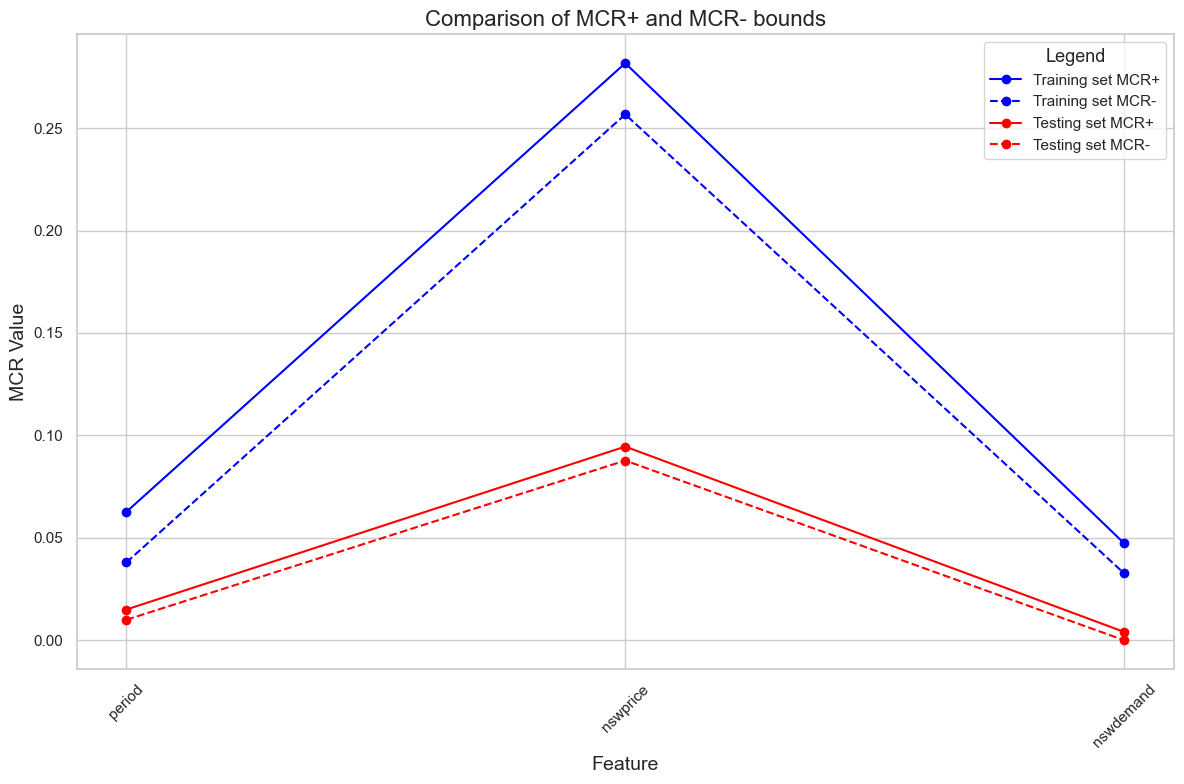

In [220]:
# Plot MCR Bounds
plt.figure(figsize=(12, 8))

# Plotting Weekday MCR+ and MCR-
plt.plot(mcr_training_df['Feature'], mcr_training_df['MCR+'], marker='o', color='blue', label='Training set MCR+')
plt.plot(mcr_training_df['Feature'], mcr_training_df['MCR-'], marker='o', color='blue', linestyle='--', label='Training set MCR-')

# Plotting Weekend MCR+ and MCR-
plt.plot(mcr_testing_df['Feature'], mcr_testing_df['MCR+'], marker='o', color='red', label='Testing set MCR+')
plt.plot(mcr_testing_df['Feature'], mcr_testing_df['MCR-'], marker='o', color='red', linestyle='--', label='Testing set MCR-')

plt.title('Comparison of MCR+ and MCR- bounds', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('MCR Value', fontsize=14)
plt.xticks(rotation=45)

plt.legend(title='Legend', title_fontsize='13', fontsize='11', loc='upper right')
plt.tight_layout()
plt.show()

In [221]:
# Statistical comparison of MCR bounds
compare_mcr_bounds(mcr_training_df, mcr_testing_df)

Features with significant differences (p < 0.05) according to the T-test:

Features with significant differences (p < 0.05) according to the KS-test:


# Model Neural Network

In [222]:
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [223]:
# Train the Neural Network Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Subset the first 10 months' records for training
training_df = elec_df.iloc[:15000]

# Define features and target
X = training_df[['period','nswprice','nswdemand']]
y = training_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])


nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5952 - loss: 0.6723 - val_accuracy: 0.6575 - val_loss: 0.6078
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.6922 - loss: 0.5718 - val_accuracy: 0.7763 - val_loss: 0.4832
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.8036 - loss: 0.4607 - val_accuracy: 0.8275 - val_loss: 0.4096
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.8273 - loss: 0.4085 - val_accuracy: 0.8154 - val_loss: 0.3974
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.8265 - loss: 0.3981 - val_accuracy: 0.8304 - val_loss: 0.3876


In [224]:
# Make predictions on the test set
y_pred_nn_probs = nn_model.predict(X_test)
y_pred_nn = (y_pred_nn_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

print("Classification Report (Neural Network):")
print(classification_report(y_test, y_pred_nn))


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
Classification Report (Neural Network):
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1648
           1       0.84      0.81      0.82      1352

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [225]:
# Set up next 10 months data as testing datasets
testing_df = elec_df.iloc[15000:30000].reset_index(drop=True)

In [226]:
# Define features and target
X2 = testing_df[['period','nswprice','nswdemand']]
y2 = testing_df['class']

In [227]:
# Make predictions on the test set
y2_pred_nn_probs = nn_model.predict(X2)
y2_pred_nn = (y2_pred_nn_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

print("Classification Report (Neural Network):")
print(classification_report(y2, y2_pred_nn))

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
Classification Report (Neural Network):
              precision    recall  f1-score   support

           0       0.65      0.99      0.79      8985
           1       0.94      0.22      0.35      6015

    accuracy                           0.68     15000
   macro avg       0.80      0.60      0.57     15000
weighted avg       0.77      0.68      0.61     15000



In [228]:
# Calculate permutation importance - window wise
nn_importance_df = calculate_permutation_importance_chunks(nn_model, X2, y2, chunk_size=1500)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
47/47 ━━━━━━━━━━

In [229]:
nn_importance_df

,period,nswprice,nswdemand
0,0.012671,0.113784,-0.001284
1,0.012170,0.174347,-0.000241
2,0.008015,0.139455,-0.002997
3,0.002457,0.058051,-0.003254
4,-0.002318,0.111560,-0.002770
5,0.000228,0.027247,-0.001412
6,0.003401,0.118988,-0.000156
7,0.013298,0.076399,-0.002048
8,0.006158,0.049115,-0.000598
9,0.004098,0.023857,-0.000879


In [230]:
# Calculate importance scores for statistical comparison
nn_importance_stat, nn_accuracy = calculate_permutation_importance_all_values(nn_model, X2, y2, chunk_size=1500)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
47/47 ━━━━━━━━━━

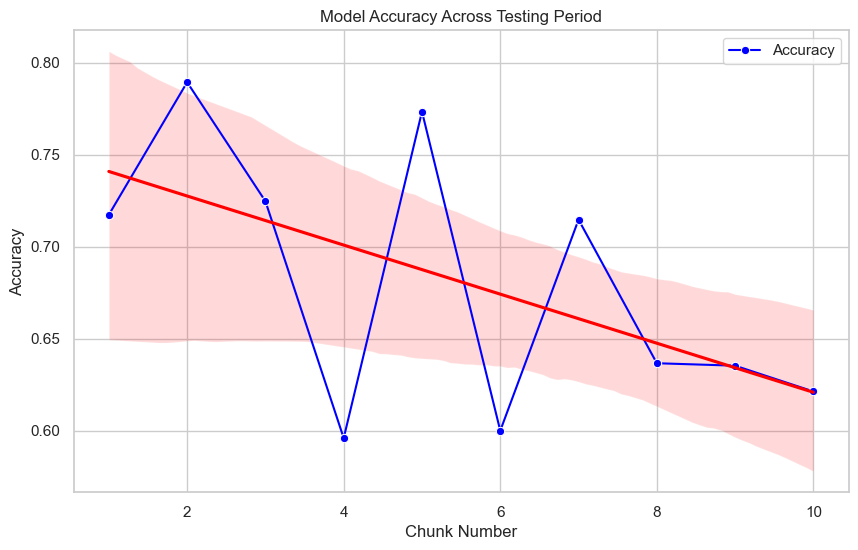

In [231]:
# Plot accuracy trend line
plot_accuracy(nn_accuracy)

In [232]:
# Check for statistical differences in importance scores
print_significant_differences(nn_importance_stat, alpha=0.05)

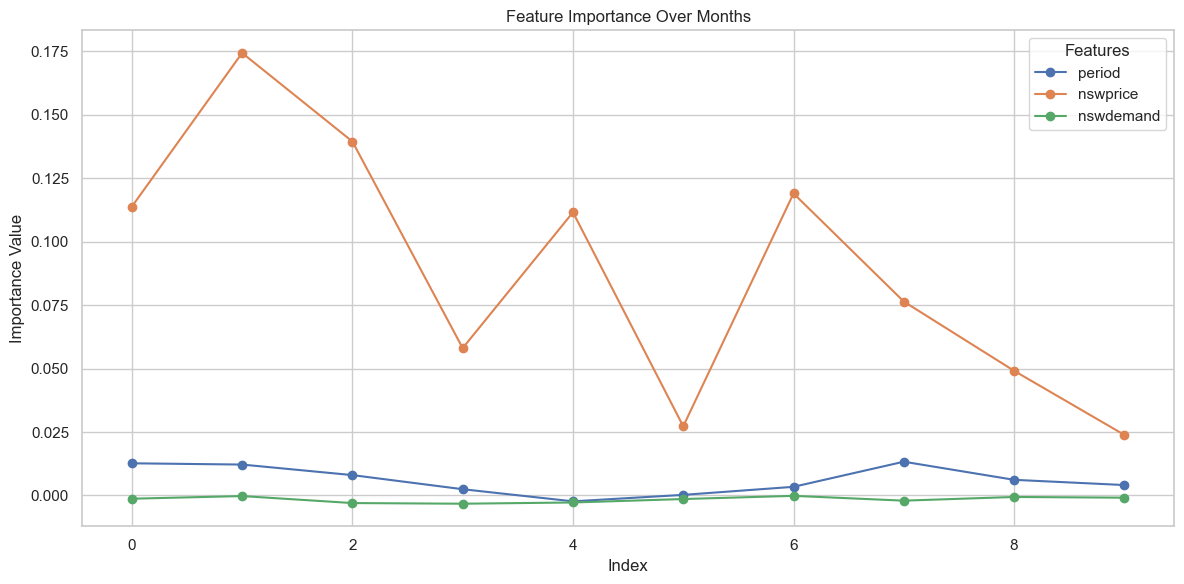

In [233]:
# Plot permutation importance scores

fig, ax = plt.subplots(figsize=(12, 6))

for feature in ['period','nswprice', 'nswdemand']:
    ax.plot(nn_importance_df.index, nn_importance_df[feature], marker='o', label=feature)


ax.set_xlabel('Index')
ax.set_ylabel('Importance Value')
ax.set_title('Feature Importance Over Months')
ax.legend(title='Features', loc='upper right')
plt.tight_layout()
plt.show()

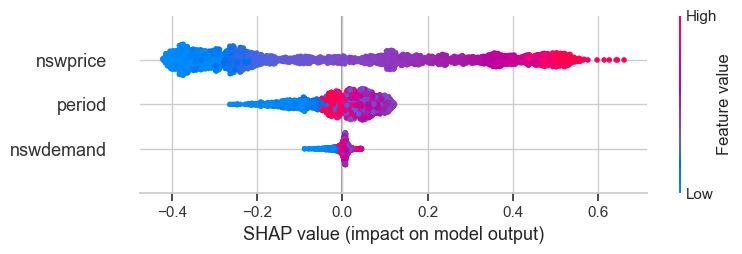

In [234]:
# SHAP Summary plot for training dataset
nn_shap_values = plot_nn_shap_graph(X_test,nn_model)

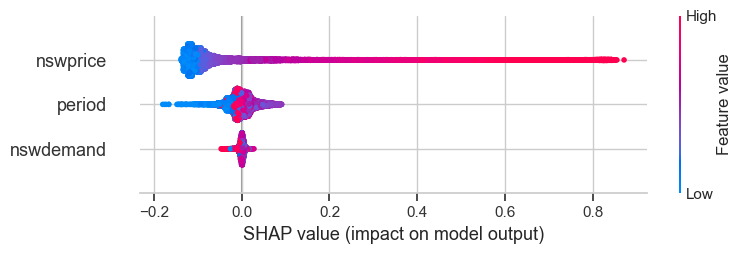

In [235]:
# SHAP Summary plot for testing dataset
nn_test_shap_values = plot_nn_shap_graph(X2,nn_model)

In [236]:
# Calculate mean, variance and skewsness of SHAP for training dataset
nn_shap_metrics = calculate_shap_metrics_lr(nn_shap_values)
nn_shap_metrics

,feature,mean,variance,skewness
0,period,-3.700743e-19,0.005595,-0.784547
1,nswprice,1.776357e-18,0.096568,0.298104
2,nswdemand,3.700743e-20,0.000232,-1.413572


In [237]:
# Calculate mean, variance and skewness of SHAP for testing dataset
nn_test_shap_metrics = calculate_shap_metrics_lr(nn_test_shap_values)
nn_test_shap_metrics

,feature,mean,variance,skewness
0,period,-3.586464e-16,0.000769,0.015957
1,nswprice,2.046363e-16,0.048377,2.457840
2,nswdemand,3.630281e-16,0.000032,-1.880622


In [238]:
# Check for statistical differences in SHAP metrics
train_stats = nn_shap_metrics.set_index('feature').to_dict('index')
test_stats = nn_test_shap_metrics.set_index('feature').to_dict('index')

n_samples = 1000
significance_level = 0.05

def simulate_shap_values(mean, variance, n_samples):
    return np.random.normal(loc=mean, scale=np.sqrt(variance), size=n_samples)

# Simulating SHAP values for training and testing datasets
shap_train = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
              for feature, stats in train_stats.items()}

shap_test = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
             for feature, stats in test_stats.items()}

# Perform t-test and KS-test for each feature
test_results = {}
for feature in shap_train.keys():
    t_stat, t_p_value = ttest_ind(shap_train[feature], shap_test[feature], equal_var=True)
    ks_stat, ks_p_value = ks_2samp(shap_train[feature], shap_test[feature])
    
    # Determine if the results are significant
    t_significant = t_p_value < significance_level
    ks_significant = ks_p_value < significance_level
    
    test_results[feature] = {
        't-test': {'t_stat': t_stat, 'p_value': t_p_value, 'significant': t_significant},
        'ks-test': {'ks_stat': ks_stat, 'p_value': ks_p_value, 'significant': ks_significant}
    }


for feature, results in test_results.items():
    print(f"Feature: {feature}")
    print(f"  t-test: t_stat={results['t-test']['t_stat']:.4f}, p_value={results['t-test']['p_value']:.4e}, "
          f"{'Significant' if results['t-test']['significant'] else 'Not Significant'}")
    print(f"  KS-test: ks_stat={results['ks-test']['ks_stat']:.4f}, p_value={results['ks-test']['p_value']:.4e}, "
          f"{'Significant' if results['ks-test']['significant'] else 'Not Significant'}")
    print()

print("Summary of features with significant differences:")
for feature, results in test_results.items():
    if results['t-test']['significant'] or results['ks-test']['significant']:
        print(f"Feature: {feature}")
        if results['t-test']['significant']:
            print(f"  Significant difference in mean based on t-test (p={results['t-test']['p_value']:.4e})")
        if results['ks-test']['significant']:
            print(f"  Significant difference in distribution based on KS-test (p={results['ks-test']['p_value']:.4e})")

Feature: period
  t-test: t_stat=1.0888, p_value=2.7636e-01, Not Significant
  KS-test: ks_stat=0.2420, p_value=4.2252e-26, Significant

Feature: nswprice
  t-test: t_stat=-0.1209, p_value=9.0377e-01, Not Significant
  KS-test: ks_stat=0.0810, p_value=2.8179e-03, Significant

Feature: nswdemand
  t-test: t_stat=-0.9224, p_value=3.5645e-01, Not Significant
  KS-test: ks_stat=0.2400, p_value=1.1290e-25, Significant

Summary of features with significant differences:
Feature: period
  Significant difference in distribution based on KS-test (p=4.2252e-26)
Feature: nswprice
  Significant difference in distribution based on KS-test (p=2.8179e-03)
Feature: nswdemand
  Significant difference in distribution based on KS-test (p=1.1290e-25)


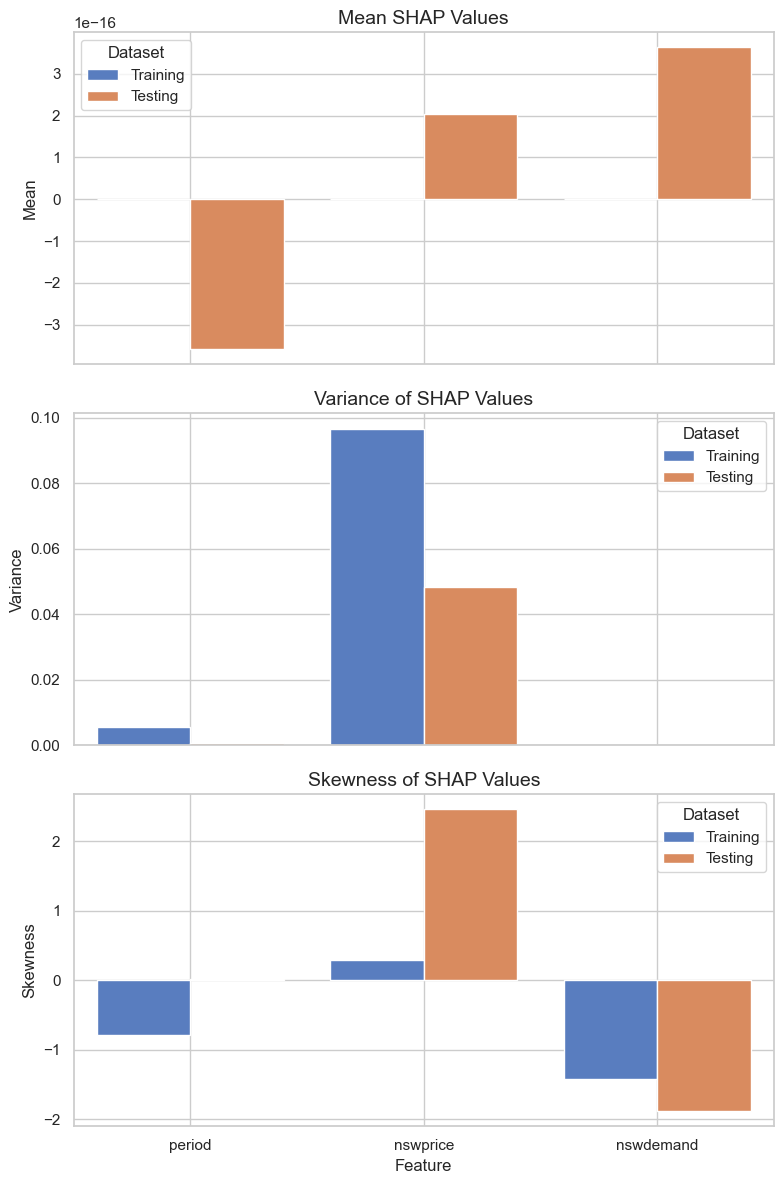

In [239]:
# Plot SHAP metrics
nn_shap_metrics['Dataset'] = 'Training'
nn_test_shap_metrics['Dataset'] = 'Testing'

# Combine the two dataframes into one
combined_shap_metrics = pd.concat([nn_shap_metrics, nn_test_shap_metrics])

import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
palette = sns.color_palette("muted")
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot mean SHAP values
sns.barplot(ax=axes[0], x='feature', y='mean', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[0].set_title('Mean SHAP Values', fontsize=14)
axes[0].set_ylabel('Mean', fontsize=12)
axes[0].grid(True)

# Plot variance of SHAP values
sns.barplot(ax=axes[1], x='feature', y='variance', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[1].set_title('Variance of SHAP Values', fontsize=14)
axes[1].set_ylabel('Variance', fontsize=12)
axes[1].grid(True)

# Plot skewness of SHAP values
sns.barplot(ax=axes[2], x='feature', y='skewness', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[2].set_title('Skewness of SHAP Values', fontsize=14)
axes[2].set_xlabel('Feature', fontsize=12)
axes[2].set_ylabel('Skewness', fontsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.show()